In [1]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

from models.LoadModels import LoadVAEmodel, initVAEmodel
from utils.data_transformers import normalize_every_image_channels_seperately_inplace
from utils.data_transformers import normalize_channels_inplace, batch_normalize_images
from utils.data_transformers import SingleCellDataset
from utils.plotting import plot_VAE_performance
from utils.data_preparation import create_directory
from utils.data_preparation import read_metadata_and_images
from utils.data_preparation import get_MOA_mappings, shuffle_metadata, split_metadata
from utils.utils import cprint, get_datetime, create_logfile, constant_seed
from utils.utils import save_model
from downstream_task import downstream_task

from utils.data_preparation import read_metadata, get_relative_image_paths, load_images

from utils.profiling import LatentVariableExtraction

import importlib

from VAE_trainer import VAE_trainer 
from VAEGAN_trainer import VAEGAN_trainer

In [2]:
from utils.data_preparation import *
from utils.data_transformers import *
from utils.plotting import *
from utils.profiling import *


In [3]:
datetime=get_datetime()
create_directory("dump/logs")
logfile = open("./dump/logs/log_{}.log".format(datetime), "w")
logfile=None

In [4]:
datetime = get_datetime()
output_folder = "dump/analyse_StandardVAE_{}/".format(datetime)
create_directory(output_folder)

In [5]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
constant_seed()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cprint(f"Using device: {device}", logfile)

08:59:59 | Using device: cpu


## Load data

In [7]:
images, metadata, mapping = read_metadata_and_images(use_server_path = False, \
                                                        load_images_from_individual_files = True, 
                                                        load_subset_of_images = 50000, 
                                                        save_images_to_singlefile = False,
                                                        logfile = logfile)


09:00:00 | Using a subset of the metadata
09:00:00 | loaded metadata
09:00:00 | loading images
09:00:00 | loading images from individual files
09:00:01 | loading images now
verbose:  True
09:00:01 | loaded 0/50000 images (0.00%).
09:00:01 | loaded 500/50000 images (1.00%).
09:00:01 | loaded 1000/50000 images (2.00%).
09:00:02 | loaded 1500/50000 images (3.00%).
09:00:02 | loaded 2000/50000 images (4.00%).
09:00:02 | loaded 2500/50000 images (5.00%).
09:00:02 | loaded 3000/50000 images (6.00%).
09:00:02 | loaded 3500/50000 images (7.00%).
09:00:02 | loaded 4000/50000 images (8.00%).
09:00:03 | loaded 4500/50000 images (9.00%).
09:00:03 | loaded 5000/50000 images (10.00%).
09:00:03 | loaded 5500/50000 images (11.00%).
09:00:03 | loaded 6000/50000 images (12.00%).
09:00:03 | loaded 6500/50000 images (13.00%).
09:00:03 | loaded 7000/50000 images (14.00%).
09:00:04 | loaded 7500/50000 images (15.00%).
09:00:04 | loaded 8000/50000 images (16.00%).
09:00:04 | loaded 8500/50000 images (17.00%)

In [8]:
%%script echo skipping

data_root = "../data/all/"
metadata_all = read_metadata(data_root + "metadata.csv")

skipping


In [9]:
%%script echo skipping
metadata_all.groupby(['moa'])['moa'].count()

skipping


In [10]:
%%script echo skipping
metadata = shuffle_metadata(metadata_all)[:50000]
mapping = get_MOA_mappings(metadata)


skipping


In [11]:
#metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
#metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

In [12]:
#metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)

In [13]:
%%script echo skipping
relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]

skipping


In [14]:
%%script echo skipping
images = load_images(image_paths, verbose=True, log_every=10000)

skipping


## Normalize data

In [15]:
normalize_every_image_channels_seperately_inplace(images)
#normalize_channels_inplace(images)
print(images.shape)

torch.Size([50000, 3, 68, 68])


## Split data

In [16]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
#test_set = SingleCellDataset(metadata_test, images, mapping)

## Load trained model

In [17]:
from models.CytoVariationalAutoencoder import CytoVariationalAutoencoder
from models.DISC import DISC
from models.SparseVariationalAutoencoder import SparseVariationalAutoencoder
from models.VariationalInference_VAE import VariationalInference_VAE
from models.VariationalInference_VAEGAN import VariationalInference_VAEGAN
from models.VariationalInference_SparseVAEGAN import VariationalInference_SparseVAEGAN
from models.VariationalInference_SparseVAE import VariationalInference_SparseVAE

def LoadVAEmodel(folder, model_type=None, device="cpu"):
    params = torch.load(folder + "params.pt", map_location=torch.device(device))

    validation_data = torch.load(folder + "validation_data.pt", map_location=torch.device(device))
    training_data = torch.load(folder + "training_data.pt", map_location=torch.device(device))
    
    model_type = params['model_type']
    if 'p_norm' in params.keys(): p_norm = params['p_norm'] 
    else: p_norm = 2

    if model_type in ['Cyto_nonvar', 'CytoVAE']:
        vae = CytoVariationalAutoencoder_nonvar(params['image_shape'], params['latent_features'])
        vae.load_state_dict(torch.load(folder + "vae_parameters.pt", map_location=torch.device(device)))
        vi = VariationalInference_VAE(beta=params['beta'], p_norm = p_norm)
        model = [vae]

    if model_type == 'SparseVAE':
        vae = SparseVariationalAutoencoder(params['image_shape'], params['latent_features'])
        vae.load_state_dict(torch.load(folder + "vae_parameters.pt", map_location=torch.device(device)))
        vi = VariationalInference_SparseVAE(beta=params['beta'], alpha=params['alpha'])
        model = [vae]
    return model, validation_data, training_data, params

In [18]:
#Cyto model nonvar
model_type  = "Cyto_nonvar"
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./dump/outputs_2022-12-02 - 22-12-04/", model_type="Cyto_nonvar")
vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./dump/outputs_2023-01-01 - 22-24-26/", model_type="Cyto_nonvar")


In [19]:
# Sparse VAE
# vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./dump/outputs_2022-12-04 - 17-58-30/")

In [20]:

vae = vae[0].to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference_SparseVAE(beta=VAE_settings['beta'])

In [21]:
#train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
#validation_loader = DataLoader(validation_set, batch_size=VAE_settings['batch_size'], shuffle=False, num_workers=0, drop_last=False)


## Latent space heatmap
1) one-hot-encoding of a variable
2) calculate correlation matrix between the hot-encoded variables and latent space variables
3) plot it out nocely

In [22]:
%%script echo skipping

# extracting latent variables for each image/cell
def LatentVariableExtraction(metadata, images, batch_size, vae):
    images.shape[0]
    batch_size=min(batch_size, len(images))
    batch_offset = np.arange(start=0, stop=images.shape[0]+1, step=batch_size)

    df = pd.DataFrame()
    new_metadata = pd.DataFrame()

    for j, item in enumerate(batch_offset[:-1]):
        start = batch_offset[j]
        end = batch_offset[j+1]
        outputs = vae(images[start:end,:,:,:])
        z = outputs["z"]
        columns_list = ["latent_"+str(z) for z in range(z.shape[1])]
        z_df = pd.DataFrame(z.detach().numpy(), columns=columns_list)
        z_df.index = list(range(start,end))
        df = pd.concat([metadata.iloc[start:end], z_df], axis=1)
        new_metadata = pd.concat([new_metadata, df], axis=0)
        print("Profiling {}/{} batches of size {}".format(j, len(batch_offset)-1, batch_size))
    
    # last batch
    start = batch_offset[-1]
    end = images.shape[0]
    if start != end:
        #print(start, end)
        outputs = vae(images[start:end,:,:,:])
        z = outputs["z"]
        #print("z.shape", z.shape)
        columns_list = ["latent_"+str(z) for z in range(z.shape[1])]
        z_df = pd.DataFrame(z.detach().numpy(), columns=columns_list)
        z_df.index = list(range(start,end))
        df = pd.concat([metadata.iloc[start:end], z_df], axis=1)
        new_metadata = pd.concat([new_metadata, df], axis=0)
        print("Profiling {}/{} batches of size {}".format(len(batch_offset)-1, len(batch_offset)-1, end-start))

    return new_metadata

skipping


In [23]:
metadata['Well_unique'] = metadata['Image_Metadata_Well_DAPI'] + '_' + metadata['Image_Metadata_Plate_DAPI']
metadata['Treatment'] = metadata['Image_Metadata_Compound'] + '_' + metadata['Image_Metadata_Concentration'].astype(str)
metadata['week'] = metadata['Image_PathName_DAPI'].str.split("_", n=1, expand = True)[0]
metadata['row_id'] = np.arange(len(metadata))
metadata_latent = LatentVariableExtraction(metadata, images, 1024, vae, 'cpu')

09:00:21 | Profiling 0/48 batches of size 1024
09:00:25 | Profiling 1/48 batches of size 1024
09:00:27 | Profiling 2/48 batches of size 1024
09:00:29 | Profiling 3/48 batches of size 1024
09:00:32 | Profiling 4/48 batches of size 1024
09:00:34 | Profiling 5/48 batches of size 1024
09:00:36 | Profiling 6/48 batches of size 1024
09:00:38 | Profiling 7/48 batches of size 1024
09:00:40 | Profiling 8/48 batches of size 1024
09:00:43 | Profiling 9/48 batches of size 1024
09:00:45 | Profiling 10/48 batches of size 1024
09:00:47 | Profiling 11/48 batches of size 1024
09:00:49 | Profiling 12/48 batches of size 1024
09:00:51 | Profiling 13/48 batches of size 1024
09:00:53 | Profiling 14/48 batches of size 1024
09:00:56 | Profiling 15/48 batches of size 1024
09:00:58 | Profiling 16/48 batches of size 1024
09:01:00 | Profiling 17/48 batches of size 1024
09:01:02 | Profiling 18/48 batches of size 1024
09:01:05 | Profiling 19/48 batches of size 1024
09:01:07 | Profiling 20/48 batches of size 1024
09

In [24]:
#metadata_latent.to_csv("help_me_notebook.csv")


In [25]:
metadata_onehot = pd.concat([metadata_latent, pd.get_dummies(metadata_latent["moa"], prefix = 'onehot_moa')], axis=1)

In [26]:
latent_cols = [col for col in metadata_onehot.columns if type(col)==str and col[0:7]=='latent_']
one_hot_cols = [col for col in metadata_onehot.columns if type(col)==str and col[0:7]=='onehot_']


In [27]:
heatmap_matrix = metadata_onehot[one_hot_cols + latent_cols].corr().filter(items=one_hot_cols, axis=0)[latent_cols]


In [28]:
heatmap_matrix.index

Index(['onehot_moa_Actin disruptors', 'onehot_moa_Aurora kinase inhibitors',
       'onehot_moa_Cholesterol-lowering', 'onehot_moa_DMSO',
       'onehot_moa_DNA damage', 'onehot_moa_DNA replication',
       'onehot_moa_Eg5 inhibitors', 'onehot_moa_Epithelial',
       'onehot_moa_Kinase inhibitors', 'onehot_moa_Microtubule destabilizers',
       'onehot_moa_Microtubule stabilizers', 'onehot_moa_Protein degradation',
       'onehot_moa_Protein synthesis'],
      dtype='object')

In [29]:
meh = [x[11:] for x in heatmap_matrix.index]
print(meh)

['Actin disruptors', 'Aurora kinase inhibitors', 'Cholesterol-lowering', 'DMSO', 'DNA damage', 'DNA replication', 'Eg5 inhibitors', 'Epithelial', 'Kinase inhibitors', 'Microtubule destabilizers', 'Microtubule stabilizers', 'Protein degradation', 'Protein synthesis']


In [30]:
heatmap_matrix.index = meh

In [31]:
#sns.heatmap(heatmap_matrix.abs(), annot=True)
#heatmap_matrix

Index(['DMSO', 'Microtubule stabilizers', 'Aurora kinase inhibitors',
       'DNA damage', 'Eg5 inhibitors', 'Epithelial', 'Kinase inhibitors',
       'Protein synthesis', 'Actin disruptors', 'DNA replication',
       'Cholesterol-lowering', 'Microtubule destabilizers',
       'Protein degradation'],
      dtype='object')


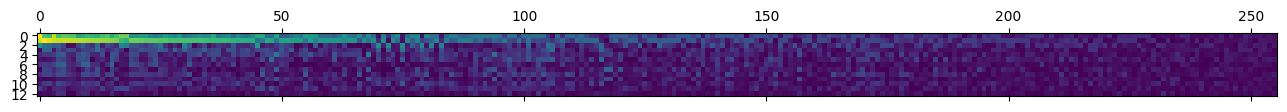

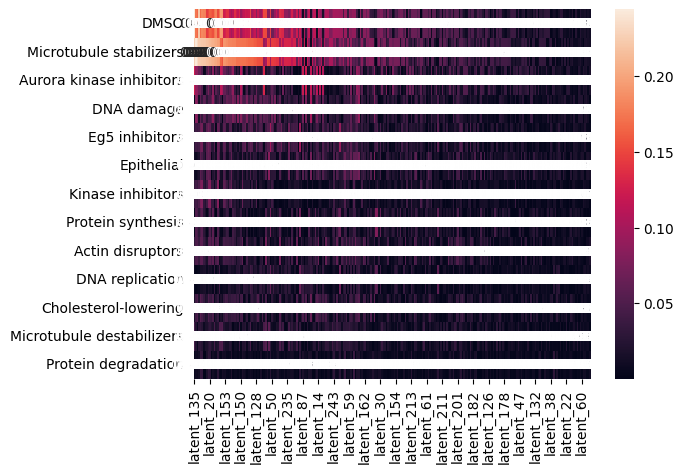

In [32]:
heatmap_matrix_abs = heatmap_matrix.abs()
heatmap_latentmax = heatmap_matrix_abs.max(axis=0)
heatmap_latent_var_order = heatmap_latentmax.sort_values(ascending=False).index
heatmap_matrix_abs_reordered = heatmap_matrix_abs[heatmap_latent_var_order]

heatmap_moa_max = heatmap_matrix_abs.max(axis=1)
heatmap_moa_order = heatmap_moa_max.sort_values(ascending=False).index
print(heatmap_moa_order)
heatmap_matrix_abs_reordered = heatmap_matrix_abs_reordered.reindex(heatmap_moa_order)
plt.matshow(heatmap_matrix_abs_reordered.to_numpy())
plt.show()
sns.heatmap(heatmap_matrix_abs_reordered, annot=True)
plt.show()


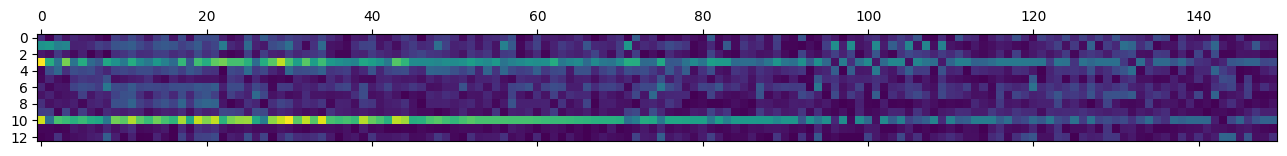

In [33]:
# Normalize each moa
heatmap_matrix_abs = heatmap_matrix.abs()
heatmap_norm = heatmap_matrix_abs.divide(heatmap_matrix_abs.mean(axis=1), axis=0)
heatmap_latentmax = heatmap_matrix_abs.max(axis=0)

#print(type(heatmap_latentmax))

#print(heatmap_latentmax[heatmap_latentmax >= heatmap_latentmax.quantile(q=0.9)])
subset_for_grouping = heatmap_latentmax[heatmap_latentmax >= heatmap_latentmax.quantile(q=0.8)]
subset_for_not_grouping = heatmap_latentmax[heatmap_latentmax < heatmap_latentmax.quantile(q=0.9)].sort_values(ascending=False)

#print(subset_for_not_grouping)

# Pick argmax for each latent. That is the group it belongs to.
heatmap_latent_belongs_to = heatmap_norm.idxmax()

heatmap_latent_belongs_to_pd = heatmap_latent_belongs_to.to_frame()
heatmap_latent_belongs_to_pd['moa_id']  = pd.factorize(heatmap_latent_belongs_to_pd[0])[0]
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    #print(heatmap_latent_belongs_to_pd.sort_values('moa_id'))
    pass

heatmap_latent_var_order = heatmap_latent_belongs_to_pd.sort_values('moa_id').index
heatmap_latent_var_order_subset = [latent for latent in heatmap_latent_var_order if latent in subset_for_grouping]
heatmap_latent_var_order_2 = heatmap_latent_var_order_subset + [latent for latent in subset_for_not_grouping.index]
#print(heatmap_latent_var_order_subset)
#print(heatmap_latent_var_order_2)

#print(heatmap_latent_belongs_to_pd.sort_values('moa_id'))
heatmap_matrix_abs_reordered = heatmap_matrix_abs[heatmap_latent_var_order_2[0:150]]
#print(heatmap_matrix_abs_reordered)
# Chose the X% latent var with highest max correct value
#print(heatmap_matrix_abs_reordered.to_numpy())
#print(heatmap_matrix_abs_reordered)
plt.matshow(heatmap_matrix_abs_reordered)
plt.savefig(output_folder + "heatmap.png")
plt.show()

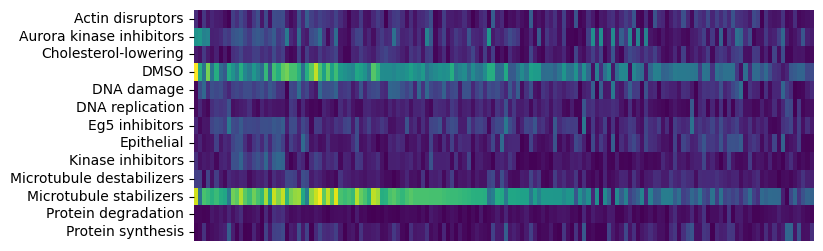

In [34]:
#viridis
plt.figure(figsize = (8,3))
sns.heatmap(heatmap_matrix_abs_reordered, cmap="viridis", xticklabels=False, cbar=False)
plt.savefig(output_folder + "heatmap_sns.png")
plt.show()

## Nearest neighbour classification
### NSC Not-Same-Compound:
1) A = Take a subset consisting of all cells form one compound.
2) B = Take the rest
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A

### NSCB Not-Same-Compound-and-Batch:
1) A = Take a subset consisting of all cells form one plate.
2) B = Take the rest
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A


In [35]:
from sklearn.neighbors import NearestNeighbors


In [36]:
#model on all observations
metadata_latent_latent_cols = metadata_latent[latent_cols]
metadata.columns


Index(['Unnamed: 0', 'Multi_Cell_Image_Id', 'Multi_Cell_Image_Name',
       'Single_Cell_Image_Id', 'Single_Cell_Image_Name', 'TableNumber',
       'ImageNumber', 'Image_FileName_DAPI', 'Image_PathName_DAPI',
       'Image_FileName_Tubulin', 'Image_PathName_Tubulin',
       'Image_FileName_Actin', 'Image_PathName_Actin',
       'Image_Metadata_Plate_DAPI', 'Image_Metadata_Well_DAPI', 'Replicate',
       'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'moa',
       'Well_unique', 'Treatment', 'week', 'row_id'],
      dtype='object')

In [37]:
metadata['NSC_class']=''

In [38]:
%%script echo skipping

NSC_var = 'week'
class_var = 'moa'

for myNSC_var in metadata_latent[NSC_var].unique():
    print("\nBegging myclass: ", myNSC_var)
    class_rows_list = metadata[metadata_latent[NSC_var] == myNSC_var]['row_id'].to_list()
    class_subset = metadata_latent[latent_cols][metadata_latent[NSC_var] == myNSC_var]
    anti_set = metadata_latent[latent_cols][metadata_latent[NSC_var] != myNSC_var]
    print("fitting to antiset")
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(anti_set)
    print("classifying")
    myclassification = nbrs.kneighbors(class_subset, 1, return_distance=False)
    myclassification_list = list(myclassification[:,0])
    for classification_row_id , metadata_row_id in enumerate(class_rows_list):
        myclass = metadata.filter(items = [myclassification_list[classification_row_id]], axis=0)[class_var].tolist()[0]
        metadata.at[metadata_row_id, 'NSC_class'] = myclass
        metadata.at[metadata_row_id, 'nearest_neighbor_NSC'] = myclassification_list[classification_row_id]
    print("\nFinished myclass: ", myclass)


skipping


## Nearest neighbour classification
1) Get profile from well
2) Get profile from unique treatment

### NSC Not-Same-Compound:
1) A = Take all the treatment-profiles with the chosen compound. 
2) B = Take the rest of the treatment-profiles.
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A

### NSCB Not-Same-Compound-and-Batch:
1) A = Take all the treatment-profiles with the chosen week & compound.
3) B = Take all treatment-profiles that are from other weeks and from other compound.
4) For each element in A, find their closest neighbor in B.
5) Use the moa class label from B as the predicted class label for elements in A


In [39]:
metadata.columns 

Index(['Unnamed: 0', 'Multi_Cell_Image_Id', 'Multi_Cell_Image_Name',
       'Single_Cell_Image_Id', 'Single_Cell_Image_Name', 'TableNumber',
       'ImageNumber', 'Image_FileName_DAPI', 'Image_PathName_DAPI',
       'Image_FileName_Tubulin', 'Image_PathName_Tubulin',
       'Image_FileName_Actin', 'Image_PathName_Actin',
       'Image_Metadata_Plate_DAPI', 'Image_Metadata_Well_DAPI', 'Replicate',
       'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'moa',
       'Well_unique', 'Treatment', 'week', 'row_id', 'NSC_class'],
      dtype='object')

In [40]:
metadata['Image_Metadata_Compound'].unique()
compound = 'taxol'

In [41]:
# Treatment Profiles
def treatment_profiles(nm):
    latent_cols = [col for col in nm.columns if type(col)==str and col[0:7]=='latent_']
    mean_over_treatment_well_unique = nm.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration','Well_unique', 'moa'], as_index=False).mean()
    median_over_treatment = mean_over_treatment_well_unique.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'moa'], as_index=False).median()
    return median_over_treatment

In [42]:
treatment_profiles_df = treatment_profiles(metadata_latent)
display(treatment_profiles_df.columns[0:20])


Index(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration',
       'moa', 'Unnamed: 0', 'Multi_Cell_Image_Id', 'Single_Cell_Image_Id',
       'TableNumber', 'ImageNumber', 'Replicate', 'row_id', 'latent_0',
       'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6',
       'latent_7', 'latent_8'],
      dtype='object')

In [43]:
NSC_var = 'Image_Metadata_Compound'
class_var = 'moa'
p=2
treatment_profiles_df['moa_pred'] = ""

for compound in metadata_latent[NSC_var].unique():
    #print("\nBeginning compound: ", compound)
    A_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] == compound]

    for A_idx, A_treatment in enumerate(A_set['Treatment']):
        B_set = treatment_profiles_df[treatment_profiles_df['Treatment'] != A_treatment]
        B_set_index_list = list(B_set.index)
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(B_set[latent_cols])
        myclassification = nbrs.kneighbors(A_set[latent_cols], 1, return_distance=False)
        myclassification_list = list(myclassification[:,0])
        #print("A_idx ", A_idx)
        nearest_in_B_set = myclassification_list[A_idx]
        #print("nearest_in_B_set: ", nearest_in_B_set)
        myclass = B_set.at[B_set_index_list[nearest_in_B_set], "moa"]
        #print("myclass: ", myclass)
        treatment_profiles_df_idx = treatment_profiles_df[treatment_profiles_df["Treatment"] == A_treatment].index[0]
        #print("treatment_profiles_df_idx:", treatment_profiles_df_idx)
        treatment_profiles_df.at[treatment_profiles_df_idx , "moa_pred"] = myclass
        #print("moa: {}".format())
    #print("\nFinished compound: ", compound)

    
        

#display(treatment_profiles_df["moa_pred", "moa"])



In [44]:
NSC_var = 'Image_Metadata_Compound'
class_var = 'moa'
p=2
treatment_profiles_df['moa_pred'] = ""

for compound in metadata_latent[NSC_var].unique():
    #print("\nBeginning compound: ", compound)
    A_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] == compound]
    B_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] != compound]
    #print("A_set.columns[0:20]: ", A_set.columns[0:20])
    #closest_neighbour = []
    #print("len(A_set): ", len(A_set))
    #print("len(B_set): ", len(B_set))
    #print(B_set.index)
    B_set_index_list = list(B_set.index)
    #print("B_set_index_list", B_set_index_list)
    #print(A_set.index)
    
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(B_set[latent_cols])
    myclassification = nbrs.kneighbors(A_set[latent_cols], 1, return_distance=False)
    myclassification_list = list(myclassification[:,0])

    for A_idx, A_treatment in enumerate(A_set['Treatment']):
        #print("A_idx ", A_idx)
        nearest_in_B_set = myclassification_list[A_idx]
        #print("nearest_in_B_set: ", nearest_in_B_set)
        myclass = B_set.at[B_set_index_list[nearest_in_B_set], "moa"]
        #print("myclass: ", myclass)
        treatment_profiles_df_idx = treatment_profiles_df[treatment_profiles_df["Treatment"] == A_treatment].index[0]
        #print("treatment_profiles_df_idx:", treatment_profiles_df_idx)
        treatment_profiles_df.at[treatment_profiles_df_idx , "moa_pred"] = myclass
        #print("moa: {}".format())
    #print("\nFinished compound: ", compound)

    
        

#display(treatment_profiles_df["moa_pred", "moa"])



In [45]:
NSC_var = 'Image_Metadata_Compound'
class_var = 'moa'
p=2

for compound in metadata_latent[NSC_var].unique():
    A_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] == compound]
    B_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] != compound]
    for A in A_set.index:
        A_treatment = A_set.loc[A]['Treatment']
        diffs = (abs(B_set[latent_cols] - A_set.loc[A][latent_cols]))**p
        diffs_sum = diffs.sum(axis=1)**(1/p)
        diffs_min = diffs_sum.min()
        res = B_set.at[diffs[diffs_sum == diffs_min].index[0], 'moa']
        treatment_profiles_df.loc[treatment_profiles_df['Treatment']==A_treatment,'moa_pred'] = res

In [46]:
print(treatment_profiles_df.groupby(['moa_pred'])['moa_pred'].count())
print(treatment_profiles_df.groupby(['moa'])['moa'].count())

moa_pred
Actin disruptors              6
Aurora kinase inhibitors     12
Cholesterol-lowering          6
DMSO                          7
DNA damage                   10
DNA replication               4
Eg5 inhibitors               12
Epithelial                    9
Kinase inhibitors             5
Microtubule destabilizers     8
Microtubule stabilizers      12
Protein degradation           5
Protein synthesis             8
Name: moa_pred, dtype: int64
moa
Actin disruptors              5
Aurora kinase inhibitors     12
Cholesterol-lowering          6
DMSO                          1
DNA damage                    9
DNA replication               8
Eg5 inhibitors               12
Epithelial                    8
Kinase inhibitors             5
Microtubule destabilizers    14
Microtubule stabilizers       9
Protein degradation           7
Protein synthesis             8
Name: moa, dtype: int64


In [47]:
print(treatment_profiles_df.groupby(['moa_pred', 'moa'])['moa_pred', 'moa'].count())

treatment_profiles_df['all']=1
treatment_profiles_df.pivot_table(values = "all", index='moa', columns='moa_pred', aggfunc=np.sum)

                                                     moa_pred  moa
moa_pred                  moa                                     
Actin disruptors          Actin disruptors                  4    4
                          Microtubule destabilizers         2    2
Aurora kinase inhibitors  Aurora kinase inhibitors         12   12
Cholesterol-lowering      Cholesterol-lowering              6    6
DMSO                      DNA damage                        1    1
                          DNA replication                   1    1
                          Protein degradation               5    5
DNA damage                DMSO                              1    1
                          DNA damage                        8    8
                          DNA replication                   1    1
DNA replication           DNA replication                   4    4
Eg5 inhibitors            Eg5 inhibitors                   10   10
                          Microtubule destabilizers         2 

/var/folders/t_/nfzp77bj23v7ypcy679dgp_80000gn/T/ipykernel_7393/3021602334.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(treatment_profiles_df.groupby(['moa_pred', 'moa'])['moa_pred', 'moa'].count())


moa_pred,Actin disruptors,Aurora kinase inhibitors,Cholesterol-lowering,DMSO,DNA damage,DNA replication,Eg5 inhibitors,Epithelial,Kinase inhibitors,Microtubule destabilizers,Microtubule stabilizers,Protein degradation,Protein synthesis
moa,,,,,,,,,,,,,
Actin disruptors,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Aurora kinase inhibitors,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cholesterol-lowering,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DMSO,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNA damage,NaN,NaN,NaN,1.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DNA replication,NaN,NaN,NaN,1.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN
Eg5 inhibitors,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,2.0,NaN,NaN
Epithelial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
Kinase inhibitors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


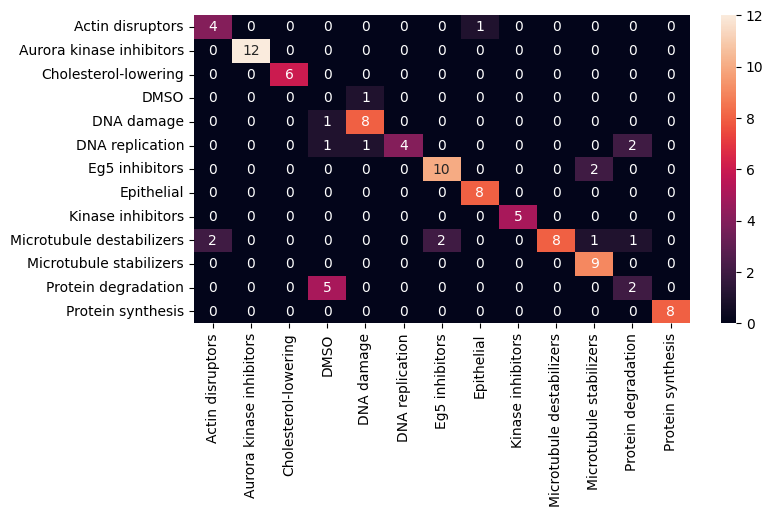

<Figure size 640x480 with 0 Axes>

In [48]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(treatment_profiles_df['moa'], treatment_profiles_df['moa_pred'])  
df_cm = pd.DataFrame(cf_matrix, index = [i for i in mapping],
                     columns = [i for i in mapping])
plt.figure(figsize = (8,4))
sns.heatmap(df_cm, annot=True)
plt.show()
plt.savefig(output_folder + "confusionmatrix.png")



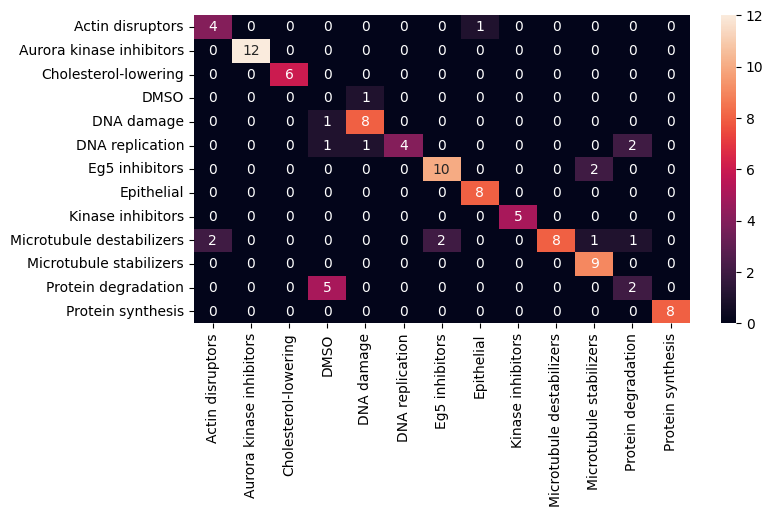

In [49]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(treatment_profiles_df['moa'], treatment_profiles_df['moa_pred'])  
df_cm = pd.DataFrame(cf_matrix, index = [i for i in mapping],
                     columns = [i for i in mapping])
plt.figure(figsize = (8,4))
svm = sns.heatmap(df_cm, annot=True)
figure = svm.get_figure()    
figure.savefig(output_folder + "confusionmatrix.png", dpi=400)
plt.show()


In [50]:
from sklearn import metrics
print(metrics.classification_report(treatment_profiles_df['moa'], treatment_profiles_df['moa_pred'], digits=4))

                           precision    recall  f1-score   support

         Actin disruptors     0.6667    0.8000    0.7273         5
 Aurora kinase inhibitors     1.0000    1.0000    1.0000        12
     Cholesterol-lowering     1.0000    1.0000    1.0000         6
                     DMSO     0.0000    0.0000    0.0000         1
               DNA damage     0.8000    0.8889    0.8421         9
          DNA replication     1.0000    0.5000    0.6667         8
           Eg5 inhibitors     0.8333    0.8333    0.8333        12
               Epithelial     0.8889    1.0000    0.9412         8
        Kinase inhibitors     1.0000    1.0000    1.0000         5
Microtubule destabilizers     1.0000    0.5714    0.7273        14
  Microtubule stabilizers     0.7500    1.0000    0.8571         9
      Protein degradation     0.4000    0.2857    0.3333         7
        Protein synthesis     1.0000    1.0000    1.0000         8

                 accuracy                         0.8077    

In [51]:
report = metrics.classification_report(treatment_profiles_df['moa'], treatment_profiles_df['moa_pred'], digits=4)
filereport = open(output_folder + "accuracy_report.txt", "w")
filereport.write(report)
filereport.close()

In [52]:
from sklearn.metrics import confusion_matrix
mean_over_treatment_well_unique = metadata_latent.groupby(['Treatment','Well_unique' ], as_index=False).mean()
print(len(mean_over_treatment_well_unique))
print(len(metadata_latent))

plt.figure(figsize = (20,10))
#sns.heatmap(treatment_profiles_df.set_index('Treatment')[latent_cols])
#sns.heatmap(metadata_latent[latent_cols][0:100])
#sns.heatmap(mean_over_treatment_well_unique[latent_cols][100:200])

962
50000


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [53]:
class_var = 'moa'
p=2

for compound in metadata_latent[NSC_var].unique():
    #print("\nBeginning compound: ", compound)
    A_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] == compound]
    B_set = treatment_profiles_df[treatment_profiles_df['Image_Metadata_Compound'] != compound]
    #print("A_set.columns[0:20]: ", A_set.columns[0:20])
    #closest_neighbour = []
    for A in A_set.index:
        A_treatment = A_set.loc[A]['Treatment']
        #print('A_treatment: ', A_treatment)
        diffs = (abs(B_set[latent_cols] - A_set.loc[A][latent_cols]))**p
        diffs_sum = diffs.sum(axis=1)**(1/p)
        diffs_min = diffs_sum.min()
        #print(treatment_profiles_df.loc[treatment_profiles_df['Treatment']==A_treatment])
        #print("diffs[diffs_sum == diffs_min]", diffs[diffs_sum == diffs_min])
        treatment_profiles_df.loc[treatment_profiles_df['Treatment']==A_treatment,'moa_pred'] = B_set.at[diffs[diffs_sum == diffs_min].index[0], 'moa']
        #closest_neighbour.append(diffs[diffs_sum == diffs_min].index[0])
display(treatment_profiles_df)

,Treatment,Image_Metadata_Compound,Image_Metadata_Concentration,moa,Unnamed: 0,Multi_Cell_Image_Id,Single_Cell_Image_Id,TableNumber,ImageNumber,Replicate,...,latent_248,latent_249,latent_250,latent_251,latent_252,latent_253,latent_254,latent_255,moa_pred,all
0,ALLN_100.0,ALLN,100.00,Protein degradation,113687.913043,1349.416667,28.739130,2.0,326.260870,2.0,...,-0.011119,0.140624,0.234166,0.049487,-0.267997,0.073692,-0.105219,-0.101186,Protein degradation,1
1,ALLN_3.0,ALLN,3.00,Protein degradation,113997.419355,1362.258065,41.258065,2.0,338.580645,2.0,...,0.039980,-0.067732,-0.041343,0.047517,-0.047368,0.145135,-0.018217,-0.026978,DMSO,1
2,AZ-A_0.1,AZ-A,0.10,Aurora kinase inhibitors,62979.122449,1158.222222,51.444444,1.0,466.163265,2.0,...,-0.051609,-0.180300,0.021063,-0.052123,0.108942,-0.012829,0.107507,0.040950,Aurora kinase inhibitors,1
3,AZ-A_0.3,AZ-A,0.30,Aurora kinase inhibitors,62592.052632,1146.230769,63.672414,1.0,462.754386,2.0,...,-0.077776,-0.094991,-0.038327,-0.053844,0.210514,-0.016058,0.107664,0.061415,Aurora kinase inhibitors,1
4,AZ-A_1.0,AZ-A,1.00,Aurora kinase inhibitors,62125.409091,1134.400000,56.500000,1.0,458.454545,2.0,...,-0.069266,-0.046135,-0.021239,0.034566,0.083299,0.000724,0.085505,0.066507,Aurora kinase inhibitors,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,vincristine_0.03,vincristine,0.03,Microtubule destabilizers,158200.741935,1674.464286,41.548387,3.0,266.580645,2.0,...,0.073943,-0.139005,0.018404,0.065157,-0.038280,-0.014504,0.092731,0.029686,Microtubule destabilizers,1
100,vincristine_0.1,vincristine,0.10,Microtubule destabilizers,157942.857143,1661.967742,35.904762,3.0,262.238095,2.0,...,0.080311,0.007860,-0.017881,0.036931,-0.168193,0.028120,0.062606,0.002122,Microtubule destabilizers,1
101,vincristine_0.3,vincristine,0.30,Microtubule destabilizers,157672.928571,1644.208333,34.250000,3.0,258.035714,2.0,...,0.086226,0.087654,-0.018167,0.141717,-0.068276,-0.029209,0.057732,-0.015288,Microtubule destabilizers,1
102,vincristine_1.0,vincristine,1.00,Microtubule destabilizers,157426.500000,1618.033333,36.562500,3.0,253.900000,2.0,...,0.108900,0.012256,0.036848,0.006936,-0.065049,0.010794,0.056822,-0.045188,Eg5 inhibitors,1


In [54]:
def treatment_profile_for_week(nm, week, treatment):
  df_cells_week_treatment = nm[(nm['week'] == week ) & (nm['Treatment'] == treatment)]
  mean_over_treatment_well_unique = df_cells_week_treatment.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration','Well_unique', 'week', 'moa'], as_index=False).mean()
  cells_week_treatment_profile = mean_over_treatment_well_unique.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'week', 'moa'], as_index=False).median()
  return cells_week_treatment_profile

def treatment_profile_remaining(nm, week, treatment):
  df_cells_not_week_treatment = nm[(nm['week'] != week ) & (nm['Treatment'] != treatment)]
  mean_over_treatment_well_unique = df_cells_not_week_treatment.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration','Well_unique', 'week', 'moa'], as_index=False).mean()
  cells_not_week_treatment_profile = mean_over_treatment_well_unique.groupby(['Treatment', 'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'week', 'moa'], as_index=False).median()
  return cells_not_week_treatment_profile


In [55]:
%%script echo skipping


NSC_var = 'Image_Metadata_Compound'
class_var = 'moa'
p=2

metadata_latent_interrim = metadata_latent.groupby(['Treatment', 'week'], as_index=False).size()

treatment_week_profiles_df = pd.DataFrame(columns=metadata_latent.columns)

for index, row in metadata_latent_interrim.iterrows():
#for week, treatment in metadata_latent_interrim():
    print("index: {}/{}".format(index, len(metadata_latent_interrim)))
    treatment = row['Treatment']
    week = row['week']
    A_treatment_week = treatment_profile_for_week(metadata_latent, week, treatment)
    B_remain = treatment_profile_remaining(metadata_latent, week, treatment)
    
    diffs = (abs(B_remain[latent_cols] - A_treatment_week[latent_cols]))**p
    diffs_sum = diffs.sum(axis=1)**(1/p)
    diffs_min = diffs_sum.min()
    treatment_profiles_df.loc[treatment_profiles_df['Treatment']==A_treatment,'moa_pred'] = B_remain.at[diffs[diffs_sum == diffs_min].index[0], 'moa']
    res = B_remain.at[diffs[diffs_sum == diffs_min].index[0], 'moa']
    A_treatment_week['moa_pred'] = res
    treatment_week_profiles_df = pd.concat([treatment_week_profiles_df, A_treatment_week], axis=0)

skipping


In [56]:
%%script echo skipping

from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(treatment_week_profiles_df['moa'], treatment_week_profiles_df['moa_pred'])  
df_cm = pd.DataFrame(cf_matrix, index = [i for i in mapping],
                     columns = [i for i in mapping])
plt.figure(figsize = (8,4))
sns.heatmap(df_cm, annot=True)

skipping


In [57]:
%%script echo skipping

from sklearn import metrics
print(metrics.classification_report(treatment_week_profiles_df['moa'], treatment_week_profiles_df['moa_pred']))

skipping


# morph plotting

In [58]:
import sklearn

def plot_cosine_similarity(x0, x1, model, file=None, title=None, control_text="Control",  target_text="Target"):
    #model could be eg. "model_dump/outputs_2022-12-04 - 12-20-15/"
    #x0.shape and x1.shape should be torch.Size([3, 68, 68])
    
    #vae, validation_data, training_data, VAE_settings = LoadVAEmodel(model)
    vae = model
    outputs0 = vae(x0[None,:,:,:])
    outputs1 = vae(x1[None,:,:,:])

    z0 = outputs0["z"].detach().numpy()
    z1 = outputs1["z"].detach().numpy()

    zs = [z0] + list(np.linspace(z0, z1, num=8)) + [z1]

    #cos = np.CosineSimilarity(dim=1, eps=1e-6)

    cp = []
    for i in range(len(zs)):
        mycosine = sklearn.metrics.pairwise.cosine_similarity(zs[i], z1)[0][0]
        #print("mycosine", mycosine)
        cp.append(mycosine)
        
        #cp.append(cos(zs[i], zs[9]).mean().detach().numpy().round(2))

    # create figure
    fig = plt.figure(figsize=(25, 10))

    # setting values to rows and column variables
    rows = 1
    columns = len(zs)

    # Adds a subplot at the 1st position
    for i in range(columns):
        if i == 0:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x0)
            plt.imshow(img)
            plt.axis('off')
        elif i == columns-1:
            fig.add_subplot(rows, columns, i+1)
            img = view_as_image_plot_format(x1)
            plt.imshow(img)
            plt.axis('off')
        else:
            fig.add_subplot(rows, columns, i+1)
            plt.imshow((torch.permute(vae.observation(torch.Tensor(zs[i]))[0], (1, 2, 0)) * 255).detach().numpy().astype(np.uint8))
            plt.axis('off')
        if i == 0:
            plt.title('Control', y=-0.20, fontsize=26)
        elif i == len(zs)-1:
            plt.title(target_text, y=-0.20, fontsize=26)
        else:
            plt.title("{:.2f}".format(cp[i]), fontsize=26)
    if file == None:
        plt.show()
    else: 
        plt.savefig(file)
        plt.show()
    
    plt.close()

In [59]:
# Treatment Profiles
def treatment_profiles(df):
  t = df.groupby(['Treatment','Well_unique'], as_index=False).mean().groupby(['Treatment']).median().iloc[:,-256:]
  return t

In [60]:
# function to get the cell closest to each Treatment profile

def treatment_center_cells(df,treatment_profiles,p=2):
  tcc = []
  for t in treatment_profiles.index:
    diffs = (abs(df[df['Treatment'] == t].iloc[:,-256:] - treatment_profiles.loc[t])**p)
    diffs_sum = diffs.sum(axis=1)**(1/p)
    diffs_min = diffs_sum.min()
    tcc.append(diffs[diffs_sum == diffs_min].index[0])
  
  return df.loc[tcc]

#treatment_center_cells(nm,t,p=2).iloc[:,-260:]

In [61]:
def plot_control_cell_to_target_cell(target, images, df, model,file = None, control='DMSO_0.0', control_text = 'DMSO',  target_text=None):
    tp = treatment_profiles(df)
    tcc = treatment_center_cells(df,tp,p=2)
    control_cell = images[tcc[tcc['Treatment'] == 'DMSO_0.0'].index[0]]
    target_cell = images[tcc[tcc['Treatment'] == target].index[0]]
    plot_cosine_similarity(control_cell, target_cell, model, file=file, title=None, control_text = control_text,  target_text=treatment) 
    return 

In [62]:
create_directory(output_folder + "morphs/")

In [63]:
for treatment in metadata_latent['Treatment'].unique():
    filename = output_folder + "morphs/" + treatment.replace('/', "_") + ".png"
    print("doing: ", filename)
    plot_control_cell_to_target_cell(treatment, images, metadata_latent, vae, file=filename,  control='DMSO_0.0', control_text = 'DMSO',  target_text=treatment)
#plot_control_cell_to_target_cell("emetine_0.3", images, metadata_latent, vae, control='DMSO_0.0')


doing:  dump/analyse_StandardVAE_2023-01-02 - 08-59-59/morphs/DMSO_0.0.png


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])